Crop Classification Accuracy: 0.9772727272727273
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        19
           1       1.00      0.95      0.98        21
           2       1.00      1.00      1.00        26
           3       1.00      1.00      1.00        20
           4       1.00      0.91      0.95        23
           5       0.95      0.88      0.91        24
           6       1.00      1.00      1.00        19
           7       0.83      0.95      0.88        20
           8       0.92      1.00      0.96        11
           9       1.00      1.00      1.00        23
          10       1.00      1.00      1.00        21
          11       1.00      1.00      1.00        19
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00        19
          14       1.00      1.00      1.00        17
          15       1.00      1.00      1.00        23
          16       1.00      1.0

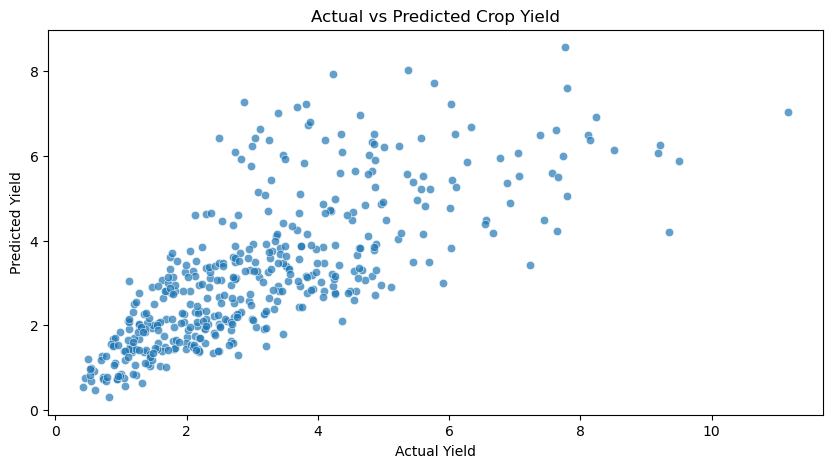

['scaler.pkl']

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error

# Load Dataset
file_path = "Crop_recommendation.csv"
df = pd.read_csv(file_path)

# Creating Interaction Features
df['N_P_ratio'] = df['N'] / (df['P'] + 1)  
df['P_K_ratio'] = df['P'] / (df['K'] + 1)
df['K_N_ratio'] = df['K'] / (df['N'] + 1)
df['humidity_temp'] = df['humidity'] / (df['temperature'] + 1)
df['rainfall_ph'] = df['rainfall'] * df['ph']

crop_mapping = {crop: idx for idx, crop in enumerate(df['label'].unique())}
df['crop_label'] = df['label'].map(crop_mapping)

X_crop = df.drop(columns=['label', 'crop_label'])
y_crop = df['crop_label']

# Train-Test Split
X_train_crop, X_test_crop, y_train_crop, y_test_crop = train_test_split(X_crop, y_crop, test_size=0.2, random_state=42)

# Scaling Features
scaler = StandardScaler()
X_train_crop = scaler.fit_transform(X_train_crop)
X_test_crop = scaler.transform(X_test_crop)

# Train XGBoost Classifier
xgb_clf = XGBClassifier(objective='multi:softmax', num_class=len(crop_mapping), eval_metric='mlogloss')
xgb_clf.fit(X_train_crop, y_train_crop)

joblib.dump(xgb_clf, "crop_classifier.pkl")

# Predict Crop
crop_preds = xgb_clf.predict(X_test_crop)
print("Crop Classification Accuracy:", accuracy_score(y_test_crop, crop_preds))
print(classification_report(y_test_crop, crop_preds))

df['yield'] = np.random.uniform(1.5, 4.5, size=len(df)) * df['rainfall'] / 100  # Simulated Yield in tons/hectare

# Splitting Features & Target for Yield Prediction
X_yield = df.drop(columns=['label', 'crop_label', 'yield'])
y_yield = df['yield']

X_train_yield, X_test_yield, y_train_yield, y_test_yield = train_test_split(X_yield, y_yield, test_size=0.2, random_state=42)

X_train_yield = scaler.fit_transform(X_train_yield)
X_test_yield = scaler.transform(X_test_yield)

# Train XGBoost Regressor
xgb_reg = XGBRegressor(objective='reg:squarederror')
xgb_reg.fit(X_train_yield, y_train_yield)

joblib.dump(xgb_reg, "yield_predictor.pkl")

# Predict Yield
yield_preds = xgb_reg.predict(X_test_yield)
print("Yield Prediction MAE:", mean_absolute_error(y_test_yield, yield_preds))
print("Yield Prediction RMSE:", np.sqrt(mean_squared_error(y_test_yield, yield_preds)))

# Visualization
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test_yield, y=yield_preds, alpha=0.7)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Crop Yield")
plt.show()

joblib.dump(scaler, "scaler.pkl")
